In [15]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tqdm
import math
import os
import xgboost
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint


### Concept

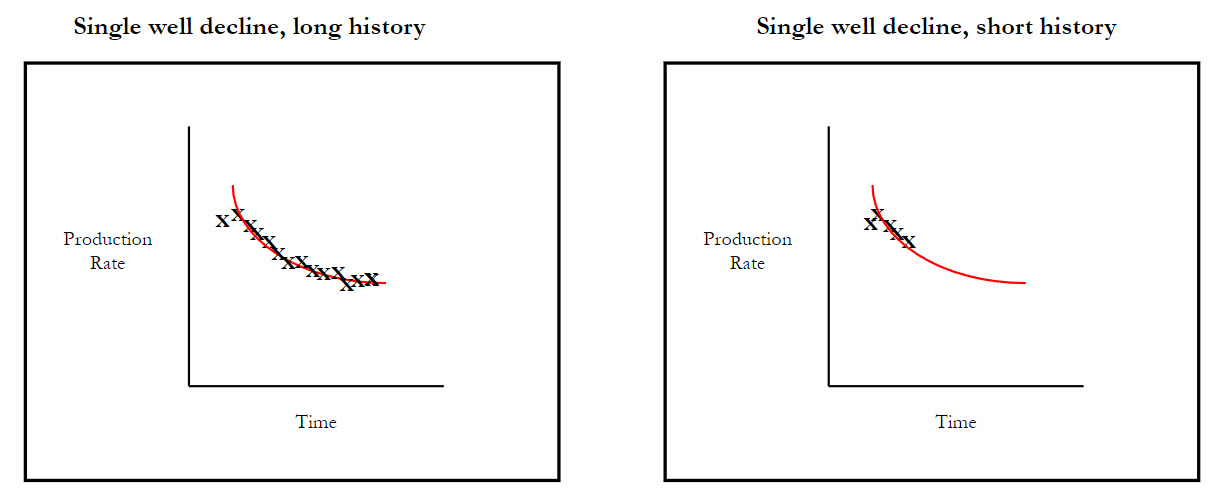

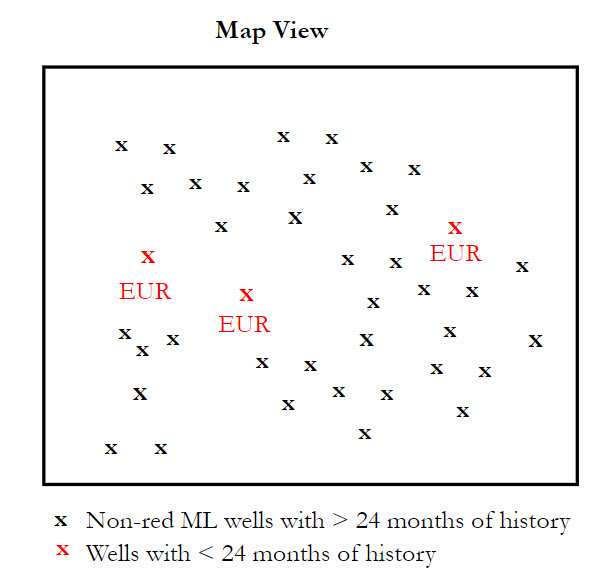

### Setup

In [16]:
'''
This code use wells with longer production history (>=25 months) as the input
And try to predict the wells with short history (<=24 months)
Featurs include the basic info of the well
Using Deep Neural Network method
'''


n_fold = 5

featureName = [
    'IP180', 
    'Non.EDC_Qi',
    'Non.EDC_b',
    'Non.EDC_Di',    
    'Surface.Latitude', 
    'Surface.Longitude', 
    'Lateral.Length', 
    'Length_of_Outliers', 
    'Volatility', 
    'IP180perEUR',
    'TVD',
    'Jan_Year_Position'
]

cont_features = featureName.copy()

### Load Data

In [17]:
%cd "G:\My Drive\Veld_Code\EFG\v811"

G:\My Drive\Veld_Code\EFG\v811


In [18]:

# Input Data
check_df = pd.read_csv('Hist_Gas_w_ML_Merge.csv')

check_df['Volatility'] = check_df['X2016_Train_Volatility']
check_df = check_df[~check_df['Volatility'].isna()]

check_df.shape

(6110, 124)

### Split the data into training set and test set

In [27]:

# use longer history wells as the train data
train_df_all = check_df[(check_df['Jan_Year_Position'] >= 25)  & 
                  (check_df['Jan_Year_Position'] <= 60)  &
                  (check_df['color_10'] == 3)]


# shuffle the train data
train_df_all_shuffle = train_df_all.sample(frac=1).reset_index(drop=True)

# create 20% of train data as validation data
valid_len = int(len(train_df_all_shuffle) * 0.2)
valid_df = train_df_all_shuffle.iloc[0:valid_len,]
train_df = train_df_all_shuffle[~train_df_all_shuffle['API.Number'].isin(valid_df['API.Number'])]



# use short history wells as the test data
test_df  = check_df[(check_df['Jan_Year_Position'] <= 24) &
                    (check_df['Jan_Year_Position'] >= 7) 
                   ]


print("# of wells in training set: {} \n# of wells in validation set: {}\n# of wells in test set: {}".format(len(train_df), len(valid_df), len(test_df)))

# of wells in training set: 945 
# of wells in validation set: 236
# of wells in test set: 617


### Feature selection

In [39]:
valid_df

,API_10,API.Number,Months.Prior,Primary.Formation,Lateral.Length,Surface.Latitude,Surface.Longitude,Volatility,X2019Qi,X2019Di,...,API_y.1,truth_25.1,preds_25.1,acc_25.1,color_25_Run2,API,truth_10_y,preds_10_y,acc_10_y,color_10_Run2
0,4231135777,42311357770000,79,EAGLE FORD,-0.679488,0.113402,0.422961,0.841522,0,0,...,4.231140e+13,1.183844,1.059481,1.183844,2.0,4.231140e+13,1.183844,1.059481,1.183844,3.0
1,4247942239,42479422390000,91,EAGLE FORD,-0.670545,-0.676150,-0.635669,-0.507305,0,0,...,4.247940e+13,1.045404,1.045719,1.045404,3.0,4.247940e+13,1.045404,1.045719,1.045404,3.0
2,4247941928,42479419280000,94,EAGLE FORD,-0.746215,-0.539439,-0.759508,-0.243394,0,0,...,4.247940e+13,0.971941,0.984119,0.971941,3.0,4.247940e+13,0.971941,0.984119,0.971941,3.0
3,4225534271,42255342710000,61,AUSTIN CHALK,1.313591,0.795868,1.052575,-0.423839,0,0,...,4.225530e+13,0.938539,1.027081,0.938539,3.0,4.225530e+13,0.938539,1.027081,0.938539,3.0
4,4228334628,42283346280000,76,EAGLE FORD,0.429150,-0.257418,0.046122,-0.613694,0,0,...,4.228330e+13,1.025043,1.059830,1.025043,2.0,4.228330e+13,1.025043,1.059830,1.025043,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,4212737060,42127370600000,63,EAGLE FORD,-0.040018,-0.430065,-0.615526,-0.674452,0,0,...,4.212740e+13,1.023035,1.028312,1.023035,3.0,4.212740e+13,1.023035,1.028312,1.023035,3.0
232,4247943012,42479430120000,71,EAGLE FORD,1.114833,-1.176375,-0.808618,-0.182102,0,0,...,4.247940e+13,0.677350,0.912041,0.677350,2.0,4.247940e+13,0.677350,0.912041,0.677350,3.0
233,4247942505,42479425050000,87,EAGLE FORD,1.126975,-0.980673,-0.448149,0.163061,0,0,...,4.247940e+13,1.136108,1.012202,1.136108,3.0,4.247940e+13,1.136108,1.012202,1.136108,3.0
234,4212332946,42123329460000,76,EAGLE FORD,1.208734,1.376811,1.534723,-0.317934,0,0,...,4.212330e+13,1.012218,0.991214,1.012218,3.0,4.212330e+13,1.012218,0.991214,1.012218,3.0


In [29]:
scaler = StandardScaler()
train_df.loc[:, featureName] = scaler.fit_transform(train_df[featureName])
valid_df.loc[:, featureName] = scaler.transform(valid_df[featureName])
test_df.loc[:, featureName] = scaler.transform(test_df[featureName])

train_inputs = train_df[featureName]
valid_inputs = valid_df[featureName]
test_inputs  = test_df[featureName]

train_labels = np.asarray(train_df['Calculated.30.yr.EUR'])
valid_labels = np.asarray(valid_df['Calculated.30.yr.EUR'])
test_labels  = np.asarray(test_df['Calculated.30.yr.EUR'])

MEAN, STD    = np.mean(train_labels), np.std(train_labels)
train_labels = (train_labels - MEAN) / STD + 1
valid_labels = (valid_labels - MEAN) / STD + 1
test_labels  = (test_labels - MEAN) / STD + 1

In [34]:
train_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945 entries, 236 to 1180
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IP180               945 non-null    float64
 1   Non.EDC_Qi          945 non-null    float64
 2   Non.EDC_b           945 non-null    float64
 3   Non.EDC_Di          945 non-null    float64
 4   Surface.Latitude    945 non-null    float64
 5   Surface.Longitude   945 non-null    float64
 6   Lateral.Length      945 non-null    float64
 7   Length_of_Outliers  945 non-null    float64
 8   Volatility          945 non-null    float64
 9   IP180perEUR         945 non-null    float64
 10  TVD                 945 non-null    float64
 11  Jan_Year_Position   945 non-null    float64
dtypes: float64(12)
memory usage: 96.0 KB


In [37]:
valid_inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IP180               236 non-null    float64
 1   Non.EDC_Qi          236 non-null    float64
 2   Non.EDC_b           236 non-null    float64
 3   Non.EDC_Di          236 non-null    float64
 4   Surface.Latitude    236 non-null    float64
 5   Surface.Longitude   236 non-null    float64
 6   Lateral.Length      236 non-null    float64
 7   Length_of_Outliers  236 non-null    float64
 8   Volatility          236 non-null    float64
 9   IP180perEUR         236 non-null    float64
 10  TVD                 236 non-null    float64
 11  Jan_Year_Position   236 non-null    float64
dtypes: float64(12)
memory usage: 22.2 KB


In [35]:
test_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 6 to 6108
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IP180               617 non-null    float64
 1   Non.EDC_Qi          617 non-null    float64
 2   Non.EDC_b           617 non-null    float64
 3   Non.EDC_Di          617 non-null    float64
 4   Surface.Latitude    617 non-null    float64
 5   Surface.Longitude   617 non-null    float64
 6   Lateral.Length      617 non-null    float64
 7   Length_of_Outliers  617 non-null    float64
 8   Volatility          617 non-null    float64
 9   IP180perEUR         617 non-null    float64
 10  TVD                 617 non-null    float64
 11  Jan_Year_Position   617 non-null    float64
dtypes: float64(12)
memory usage: 62.7 KB


### Deep Neural Network

#### 1 - Build a model

In [41]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=32, activation='relu', input_shape=[len(featureName)], name='hidden_1'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=32, activation='relu', name='hidden_2'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=16, activation='linear', name='hidden_3'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=1, activation='linear', dtype='float32', name='labels')
    ])

    optimizer = tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse', 'mape'])
    return model  

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 32)                416       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
hidden_3 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
labels (Dense)               (None, 1)                

#### 2 - Training the model

In [42]:
best_model_callback = ModelCheckpoint(filepath=os.path.join('./model', 'best_checkpoint'),
                                              monitor='val_mape',
                                              mode='min',
                                              save_weights_only=True,
                                              save_best_only=True)

history = model.fit(train_inputs, 
                    train_labels,
                    epochs=200,
                    batch_size=128,
                    validation_data=(valid_inputs, valid_labels),
                    callbacks=[best_model_callback],
                    shuffle=True,
                    verbose=1)

Epoch 1/200
8/8 [==============================] - 0s 15ms/step - loss: 3.0757 - mse: 3.0757 - mape: 941.4288 - val_loss: 1.0523 - val_mse: 1.0523 - val_mape: 114.8673
Epoch 2/200
8/8 [==============================] - 0s 2ms/step - loss: 2.6820 - mse: 2.6820 - mape: 545.9251 - val_loss: 0.9635 - val_mse: 0.9635 - val_mape: 106.1752
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 2.3013 - mse: 2.3013 - mape: 597.7642 - val_loss: 0.9206 - val_mse: 0.9206 - val_mape: 100.0023
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 2.1127 - mse: 2.1127 - mape: 630.0120 - val_loss: 0.8819 - val_mse: 0.8819 - val_mape: 96.2700
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 1.7887 - mse: 1.7887 - mape: 425.9587 - val_loss: 0.8515 - val_mse: 0.8515 - val_mape: 90.1477
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 1.5951 - mse: 1.5951 - mape: 667.5845 - val_loss: 0.8467 - val_mse: 0.8467 - val_mape: 85.3242


#### 3 - Evaluate the model

In [44]:
model.load_weights(os.path.join('./model', 'best_checkpoint'))
model.evaluate(test_inputs, test_labels)
preds = model.predict(test_inputs)

PREDS = (preds[:, 0]-1) * STD + MEAN
GT = (test_labels-1) * STD + MEAN

20/20 [==============================] - 0s 372us/step - loss: 0.3642 - mse: 0.3642 - mape: 159.4332


In [49]:

print('MEAN y_hat is {}'.format(np.mean(np.abs(PREDS))))
print('MEAN ground truth is {}'.format(np.mean(np.abs(GT))))
print('MAE is {}'.format(np.mean(np.abs((GT - PREDS)))))
print('Std of MAE is {}'.format(np.std(np.abs((GT - PREDS)))))
print("RMSE score: {}".format(mean_squared_error(GT, PREDS, squared=False)))
print("R2 score: {}".format(r2_score(GT, PREDS)))

MEAN y_hat is 2819944.5
MEAN ground truth is 3137762.6757337274
MAE is 846922.5023573582
Std of MAE is 994926.3516087492
RMSE score: 1306581.865068066
R2 score: 0.7909109003167599


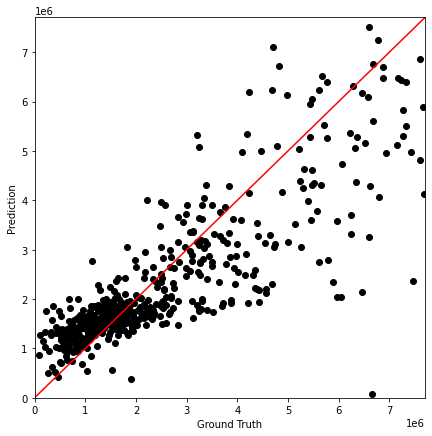

In [51]:


fig, ax = plt.subplots()
ax.scatter(GT, PREDS, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlim([0, 4*np.median(GT)])
plt.ylim([0, 4*np.median(GT)])
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.rcParams["figure.figsize"] = (7, 7)
plt.show()


#### 4 - Stats of baseline

In [56]:
baselines = np.asarray(check_df[check_df['API.Number'].isin(test_df['API.Number'])]['EUR_30yrs_Non_EDC'])


print('MEAN y_hat is {}'.format(np.mean(np.abs(baselines))))
print('MEAN ground truth is {}'.format(np.mean(np.abs(GT))))
print('MAE is {}'.format(np.mean(np.abs((GT - baselines)))))
print('Std of MAE is {}'.format(np.std(np.abs((GT - baselines)))))
print("RMSE score: {}".format(mean_squared_error(GT, baselines, squared=False)))
print("R2 score: {}".format(r2_score(GT, baselines)))



MEAN y_hat is 3055028.4595788247
MEAN ground truth is 3137762.6757337274
MAE is 1040491.3536061182
Std of MAE is 1493002.239515363
RMSE score: 1819801.6221904468
R2 score: 0.5943922577816907
